In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

from textwrap import wrap

pd.set_option('display.max_columns', None) # enable showing all columns of the df
pd.set_option('display.max_rows', None)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)

In [3]:
dataset_file_path = 'data/preprocessed_dataset.csv'
df = pd.read_csv(dataset_file_path)
df.sample(5)

,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro",IGF-1 ng/ml (N: 100-311),proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Hypertension,Waist Circumference (WC),WC>88,Hip Circumference (HC),WHR (Waist/Hip ratio),"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)",WHTR (Waist/Height Ratio),"WHTR>0,5","overweight/obesity 0-normal/low, 1-overweight, 2-obesity","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,FG score (Ferriman-Gallway score - stopień androgenizacji),hyperandrogenism,hypothyroidism,Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,"nodules 0-lack, 1-RL, 2-LL, 3-both",chronic thyroiditis,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,follicules >12,hyperlipidemia,elevated LDL and TG,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,NRBC x10^3/ul,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,CHOL>200,HDL mg/dl,HDL mmol/l,HDL<50,LDL mg/dl,LDL mmol/l,LDL>135,TG,TG mmol/l,TG>150,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",Impaired Fasting Glucose,Impaired Glucose Tolerance,TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),month of birth,quarter of the year,birth weight,birth length,week of gestation,age
562,1,NaN,NaN,NaN,77.0,153.5,32.467532,111.0,77.0,0.0,92.5,1.0,98.0,0.943878,1.0,1.0,0.602606,1.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.845000,3.78000,8.625000,0.0,1.0,6.90,9.310,16.210,1.0,0.0,0.0,8.94,5.89,2.53,0.44,0.04,0.04,66.0,28.3,4.9,0.4,0.4,4.41,11.1,35.2,3.171171,79.80,25.2,31.5,14.6,0.0,329.0,11.6,10.30,27.2,36.800895,0.031307,130.039526,5.750000,2.328063,0.282998,0.004474,140.0,4.60,9.67,NaN,0.59,NaN,18.0,13.0,0.13,117.0,3.02562,0.0,39.0,1.00854,1.0,74.0,1.913640,0.0,60.0,0.67740,0.0,1.897436,1.538462,1.190354,45.636364,23.37030,4.339656,0.187087,NaN,NaN,NaN,NaN,52.0,98.0,140.0,20.20,117.00,4.887901,2.48,0.303345,0.0,1.0,2.02,4.86,15.30,9.0,11.0,7.0,14.4,2.057143,379.0,381.0,1.1,0.317003,0.062500,132.490908,NaN,375.0,152.0,42.0,17.6,6.25,22.60,NaN,NaN,2.40,2.24,543.0,0.002026,0.458333,3.0,1.0,NaN,NaN,NaN,20.0
596,1,309.0,NaN,NaN,52.0,156.0,21.367521,128.0,92.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,5.496525,3.31947,8.815995,NaN,NaN,27.97,17.390,45.360,1.0,0.0,0.0,6.91,3.50,2.40,0.50,0.43,0.08,50.7,34.7,7.2,6.2,1.2,4.60,13.7,39.8,2.905109,86.50,29.8,34.4,14.1,0.0,312.0,10.5,9.87,23.0,45.151954,0.031635,130.000000,4.800000,1.458333,0.347323,0.062229,141.0,4.13,9.38,3.63,0.77,0.3,12.0,19.0,0.78,160.0,4.13760,0.0,72.0,1.86192,0.0,78.1,2.019666,0.0,51.0,0.57579,0.0,1.084722,0.708333,NaN,NaN,NaN,NaN,-0.14

In [4]:
df.shape

(999, 146)

In [5]:
target_column = 'PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro'

igf = 'IGF-1 ng/ml (N: 100-311)'
vit_d = 'vitamin 25-OH D ng/ml'
prolactin = 'prolactin'

important_attributes = [igf, vit_d, prolactin]

(array([232.,   0., 510.,   0.,   0., 145.,   0.,  27.,   0.,  85.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

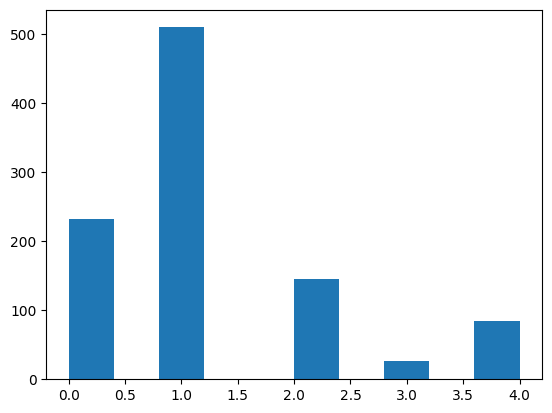

In [6]:
plt.hist(df[target_column])

### Data preprocessing

Remove columns with > 60% of missing data: 

In [7]:
def get_columns_with_high_percentage_missing_values(X, percentage=0.6):
    missing_percentage = X.isnull().mean()

    columns_to_drop = missing_percentage[missing_percentage > percentage].index
    return columns_to_drop

columns_to_drop = get_columns_with_high_percentage_missing_values(df)
print(f'Dropped columns: {list(columns_to_drop)}')
df.drop(columns=columns_to_drop, inplace=True)

Dropped columns: ['birth weight', 'birth length', 'week of gestation']


### Attribute groups

In [8]:
categorical_attributes = [
    'PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro', 'Hypertension', 'WC>88', 'WHR>0,85 (WHO)', 'WHR>0,8 (NIDDK)', 'WHTR>0,5', 
    'overweight/obesity 0-normal/low, 1-overweight, 2-obesity', 'irregular cycles (0-nie, 1-tak)', 'ovulation (0-brak, 1-obecna)', 'PCO ovary morfology in USG (0-brak, 1--obecna)',
    'stromal hypertrophy in ovary (0-brak, 1-obecny)', 'acne', 'hirsutism', 'hyperandrogenism', 'hypothyroidism', 'nodules 0-lack, 1-RL,  2-LL, 3-both', 'chronic thyroiditis',
    'follicules >12', 'hyperlipidemia', 'elevated LDL and TG', 'CHOL>200', 'HDL<50', 'LDL>135', 'TG>150', 'Impaired Fasting Glucose ', 'Impaired Glucose Tolerance', 
    # 'month of birth', 'quarter of the year',
    ]

continuous_attributes = list(df.columns.drop(categorical_attributes))

# parametry związane z układem krążenia i ryzykiem jego chorób
circulatory_system_attributes = [
    'proBNP', 'systolic BP (ciśnienie skurczowe)', 'diastolic BP (ciśnienie rozskurczowe)', 'Hypertension', 'hyperlipidemia', 'elevated LDL and TG',
    'CHOL mg/dl ', 'CHOL mmol/l', 'CHOL>200', ' HDL mg/dl', 'HDL mmol/l', 'HDL<50', 'LDL mg/dl', 'LDL mmol/l', 'LDL>135', 'TG', 'TG mmol/l', 'TG>150',
    'Atherogenic index (AI) (LDL-C/HDL-C) ', 'coronary risk index (CRI) (TG/HDL-C)', 'VAI - Visceral adiposity index', 'BAI - Body adiposity index',
    'LAP INDEX - Lipid accumulation product index', 'TyG Index - Trigliceride-glucose index', 'AIP -Atherogenic index of plasma',
    ]
# hormony płciowe plus morfologia jajnika
sex_hormones_attributes = [
    'AMH (ng/ml) *7,14=pmol/l', 'irregular cycles (0-nie, 1-tak)', 'ovulation (0-brak, 1-obecna)', 'PCO ovary morfology in USG (0-brak, 1--obecna)',
    'stromal hypertrophy in ovary (0-brak, 1-obecny)', 'acne', 'hirsutism', 'FG score (Ferriman-Gallway score - stopień androgenizacji)', 'hyperandrogenism',
    'Vole of the Right Ovary', 'Volume of the  Left Ovary', 'ovaries volume - total', 'follicules >12', 'FSH mlU/ml', 'LH', 'LH/FSH', 'DHEA-S ug/dl', 'testosterone nmol/l',
    'T (ng/ml)', 'T/SHBG', 'E(pg/ml)/T(ng/ml)/', 'Estradiol pg/ml', 'SHBG nmol/l', 'FTI (free testosterone index)', 'Androstendione ng/ml', '17-OH-progesterone ng/ml',
    'Dihydrotestosterone pg/ml (N<368)', 'Testosterone/DHT', 'T/A (testosterone/androstendione)',
    ]
# gospodarka węglowodanowa (włączając oporność i wrazliwość na insulinę)
carbohydrate_metabolism_attributes = [
    'glucose 0 mg/dl', 'glucose  120 mg/dl', 'insulin 0 uU/ml', 'Insulin 120 uU/ml', 'HOMA', 'Matsuda', 'QUICKI (N<0,357)', 'Impaired Fasting Glucose ',
    'Impaired Glucose Tolerance',
    ]
# parametry antropometryczne
anthropometric_attributes = [
    'weight', 'height (cm)', 'BMI', 'Waist Circumference (WC)', 'WC>88', 'Hip Circumference (HC)', 'WHR (Waist/Hip ratio)', 'WHR>0,85 (WHO)',
    'WHR>0,8 (NIDDK)', 'WHTR (Waist/Height Ratio)', 'WHTR>0,5', 'overweight/obesity 0-normal/low, 1-overweight, 2-obesity',
    ]
# parametry tarczycowe
thyroid_attributes = [
    'hypothyroidism', 'Volume of the thyroid  Right Lobe', 'Volume of the thyroid  Left Lobe', 'thyroid volume', 'nodules 0-lack, 1-RL,  2-LL, 3-both',
    'chronic thyroiditis', 'TSH mIU/L', 'FT3 pmol/l', 'FT4 pmol/l', 'Anty-TPO IU/ml', 'Anty-TG IU/ml',
    ]
# parametry zapalne
inflammatory_attributes = [
    'WBC x10^3/ul', 'neutrophil x10^3/ul', 'lymphocytes x10^3/ul', 'monocytes x10^3/ul', 'eosinocytes x10^3/ul', 'basophils x10^3/ul', '% neutrophil ', '% lymphocytes ',
    '% monocytes', '%eosinocytes ', '%basophils ', 'RBC x10^6ul', 'Hemoglobin [g/dl]', 'hematocrit [%]', 'HTC/Hb', 'MCV fl', 'MCH pg', 'MCHC g/dl', 'RDW-CV %', 'NRBC x10^3/ul',
    'PLT x10^3/ul', 'PDW fl', 'MPV fl', 'P-LCR %', 'PLT/WBC', 'MPV/PLT', 'PLR', 'limf/mono', 'NLR (stosunek neutrofili do limfocytów)',
    'L/WCC (leukocyty do całkowitej liczby krwinek białych)', 'eos/leukocyty', 'CRP mg/l',
    ]
#  gospodarka żelazowa
iron_attributes = ['UIBC ug/dl', 'ferrum ug/dl', 'TIBC', 'TSAT', 'ferritin ng/ml']
# gospodarka wapniowo-fosforanowa
calcium_attributes = ['calcium mg/dl', 'phosphorus mg/dl', 'Parathormone pg/ml']

attribute_groups = [
    circulatory_system_attributes, sex_hormones_attributes, carbohydrate_metabolism_attributes, anthropometric_attributes,
    thyroid_attributes, inflammatory_attributes, iron_attributes, calcium_attributes]

In [9]:
df[categorical_attributes] = df[categorical_attributes].astype('Int8')
df[continuous_attributes] = df[continuous_attributes].astype('Float64')

In [10]:
continuous_attributes

['IGF-1 ng/ml (N: 100-311)',
 'proBNP',
 'AMH (ng/ml) *7,14=pmol/l',
 'weight',
 'height (cm)',
 'BMI',
 'systolic BP (ciśnienie skurczowe)',
 'diastolic BP (ciśnienie rozskurczowe)',
 'Waist Circumference (WC)',
 'Hip Circumference (HC)',
 'WHR (Waist/Hip ratio)',
 'WHTR (Waist/Height Ratio)',
 'FG score (Ferriman-Gallway score - stopień androgenizacji)',
 'Volume of the thyroid  Right Lobe',
 'Volume of the thyroid  Left Lobe',
 'thyroid volume',
 'Vole of the Right Ovary',
 'Volume of the  Left Ovary',
 'ovaries volume - total',
 'WBC x10^3/ul',
 'neutrophil x10^3/ul',
 'lymphocytes x10^3/ul',
 'monocytes x10^3/ul',
 'eosinocytes x10^3/ul',
 'basophils x10^3/ul',
 '% neutrophil ',
 '% lymphocytes ',
 '% monocytes',
 '%eosinocytes ',
 '%basophils ',
 'RBC x10^6ul',
 'Hemoglobin [g/dl]',
 'hematocrit [%]',
 'HTC/Hb',
 'MCV fl',
 'MCH pg',
 'MCHC g/dl',
 'RDW-CV %',
 'NRBC x10^3/ul',
 'PLT x10^3/ul',
 'PDW fl',
 'MPV fl',
 'P-LCR %',
 'PLT/WBC',
 'MPV/PLT',
 'PLR',
 'limf/mono',
 'NLR 

## Train test split

In [11]:
igf_df = df.dropna(subset=[igf])

X, y = igf_df.drop(columns=[igf]), igf_df[igf]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Data Scaling

Robust Scaler

In [12]:
#  TODO: create a pretty pipeline that I can reuse later on for predicting other params


# scaler = RobustScaler().fit(X_train)

# X_train_robust_scaler = pd.DataFrame(transformer.transform(X_train), columns=X_train.columns)
# X_test_robust_scaler = pd.DataFrame(transformer.transform(X_test), columns=X_test.columns)


In [13]:
X_train.shape

(507, 142)

In [14]:
X_train.head()

,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro",proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Hypertension,Waist Circumference (WC),WC>88,Hip Circumference (HC),WHR (Waist/Hip ratio),"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)",WHTR (Waist/Height Ratio),"WHTR>0,5","overweight/obesity 0-normal/low, 1-overweight, 2-obesity","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,FG score (Ferriman-Gallway score - stopień androgenizacji),hyperandrogenism,hypothyroidism,Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,"nodules 0-lack, 1-RL, 2-LL, 3-both",chronic thyroiditis,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,follicules >12,hyperlipidemia,elevated LDL and TG,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,NRBC x10^3/ul,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,CHOL>200,HDL mg/dl,HDL mmol/l,HDL<50,LDL mg/dl,LDL mmol/l,LDL>135,TG,TG mmol/l,TG>150,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",Impaired Fasting Glucose,Impaired Glucose Tolerance,TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),month of birth,quarter of the year,age
765,2,17.08,4.822129,72.0,170.0,24.913495,122.0,74.0,0,71.0,0,90.0,0.788889,0,0,0.417647,0,0,1,<NA>,<NA>,<NA>,0,1,8.0,1,0,13.2,8.55,21.75,0,1,<NA>,<NA>,<NA>,<NA>,0,0,5.62,3.49,1.57,0.33,0.21,0.02,62.1,27.9,5.9,3.7,0.4,4.5,13.3,39.0,2.932331,86.7,29.6,34.1,11.7,0.0,208.0,12.7,10.7,31.0,37.010676,0.051442,132.484076,4.757576,2.22293,0.279359,0.037367,143.0,4.17,9.66,3.54,0.73,0.7,8.0,12.0,0.35,175.0,4.5255,0,77.0,1.99122,0,89.4,2.311884,0,46.0,0.51934,0,1.161039,0.597403,0.415334,34.941176,6.75142,4.158639,-0.223733,<NA>,96.0,343.0,28.0,36.0,89.0,92.0,13.26,40.42,2.913926,4.77,0.325528,0,0,2.77,4.85,15.23,8.0,10.0,6.0,8.3,1.383333,311.0,335.0,0.8,0.230548,0.013378,147.474999,32.45,215.0,58.0,34.0,59.8,1.27,15.76,4.6,9.0,3.2,1.4,205.0,0.003902,0.25,11.0,4.0,22.0
657,1,44.12,34.42,71.0,170.0,24.567474,126.0,86.0,0,80.0,0,86.0,0.930233,1,1,0.470588,0,0,1,0,1,1,0,1,10.0,1,1,6.375,5.64,12.015,0,1,18.7,22.59,41.29,1,0,0,6.37,3.59,1.68,0.47,0.56,0.07,53.6,26.4,7.4,8.8,1.1,4.28,13.3,37.8,2.842105,88.3,31.1,35.2,12.4,0.0,221.0,13.2,10.9,32.4,34.693878,0.049321,131.547619,3.574468,2.136905,0.263736,0.087912,144.0,4.28,9.5,2.21,0.95,0.6,8.0,15.0,0.7,184.0,4.75824,0,58.0,1.49988,0,99.7,2.578242,0,132.0,1.49028,0,1.718966,2.275862,1.796868,32.588235,32.78616,4.662727,0.357146,135.0,191.0,326.0,58.0,26.0,85.0,73.0,6.59,17.21,1.383086,13.78,0.363861,0,0,3.7,5.01,14.59,15.0,251.0,4.9,14.8,3.020408,311.0,193.0,2.7,0.778098,0.057325,100.2

In [15]:


# save the original order
original_order_attributes = list(df.columns)
original_order_attributes.remove(igf)

# define new temporary order for the attributes (for scaling purposes)
tmp_order_of_attributes = continuous_attributes + categorical_attributes
# remove igf - our target col
tmp_order_of_attributes.remove(igf)

# temp use the new order
X_train = X_train[tmp_order_of_attributes]
X_test = X_test[tmp_order_of_attributes]

# remove igf - our target col
attributes_to_scale = continuous_attributes.copy()
attributes_to_scale.remove(igf)


# scaling
robust_scaler = ColumnTransformer(
    transformers=[
        ('numeric', RobustScaler(), attributes_to_scale)
    ],
    remainder='passthrough',
)

X_train_robust_scaler = pd.DataFrame(robust_scaler.fit_transform(X_train), columns=tmp_order_of_attributes)
X_train_robust_scaler = X_train_robust_scaler[original_order_attributes]

X_test_robust_scaler = pd.DataFrame(robust_scaler.fit_transform(X_test), columns=tmp_order_of_attributes)
X_test_robust_scaler = X_test_robust_scaler[original_order_attributes]

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:702: FutureWarning: The output of the 'remainder' transformer for column 'Hypertension' has dtype Int8 and uses pandas.NA to represent null values. Storing this output in a numpy array can cause errors in downstream scikit-learn estimators, and inefficiencies. Starting with scikit-learn version 1.6, this will raise a ValueError. To avoid this problem you can (i) store the output in a pandas DataFrame by using ColumnTransformer.set_output(transform='pandas') or (ii) modify the input data or the 'remainder' transformer to avoid the presence of pandas.NA (for example by using pandas.DataFrame.astype).
  warnings.warn(
c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:702: FutureWarning: The output of the 'remainder' transformer for column 'WC>88' has dtype Int8 and uses pandas.NA to represent null values. Storing this

In [16]:
def scale_df(X, missing_attribute, scaling_method=RobustScaler()):
    # save the original order of columns
    original_order_columns = list(X.columns)
    # define new temporary order for the columns (for scaling purposes)
    tmp_order_of_columns = continuous_attributes + categorical_attributes
    tmp_order_of_columns.remove(missing_attribute)

    columns_to_scale = continuous_attributes.copy()
    columns_to_scale.remove(missing_attribute)

    X_tmp = X[tmp_order_of_columns]

    # scaling
    scaler = ColumnTransformer(
        transformers=[
            ('numeric', scaling_method, columns_to_scale)
        ],
        # so that the categorical columns remain unchanged
        remainder='passthrough',
    )

    # firstly save it to DataFrame with the correct column names
    X_scaled = pd.DataFrame(robust_scaler.fit_transform(X_tmp), columns=tmp_order_of_columns)
    # print(original_order_columns)
    X_scaled = X_scaled[original_order_columns]

    return X_scaled, scaler


## Tests for scaling method

In [17]:
def round_numeric_values(arr, decimals=5):
    # Create a mask to identify non-null numeric values
    mask = np.isnan(arr)
    # Round only the numeric values using the mask
    arr_rounded = np.where(mask, np.round(arr, decimals), arr)
    
    return arr_rounded


def test_scaler__scales_properly(scaler=RobustScaler()):
    column_1 = 'thyroid volume'
    column_2 = ' HDL mg/dl'
    column_3 = 'prolactin'
    columns_to_test = [column_1, column_2, column_3]


    for column in columns_to_test:
        df_tmp = df.drop(columns=[igf])

        # expected
        scaler = scaler
        expected_column = scaler.fit_transform(df_tmp[[column]])

        # result
        scaled_df, _ = scale_df(df_tmp, igf, scaling_method=scaler)
        result_column = scaled_df[[column]].astype('float64').values

        expected_column_rounded = round_numeric_values(expected_column)
        result_column_rounded = round_numeric_values(result_column)

        # Create masks to exclude NaN values
        expected_mask = ~np.isnan(expected_column_rounded)
        result_mask = ~np.isnan(result_column_rounded)

        try:
            # Compare only non-NaN values
            assert np.array_equal(expected_column_rounded[expected_mask], result_column_rounded[result_mask])
            print(column, "PASSED")
        except AssertionError:
            diff_indices = np.where(expected_column_rounded != result_column_rounded)[0]
            print(f"Arrays differ in column {column} at indices: {diff_indices}")
    

def test_scaler__categorical_variables_remain_unchanged(scaler=RobustScaler()):
    column_1 = 'PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro'
    column_2 = 'LDL>135'
    column_3 = 'Impaired Glucose Tolerance'

    columns_to_test = [column_1, column_2, column_3]

    for column in columns_to_test:
        df_tmp = df.drop(columns=[igf])

        scaled_df, _ = scale_df(df_tmp, igf, scaling_method=scaler)
        result_column = scaled_df[[column]].astype("Int8")

        try:
            assert result_column.equals(df_tmp[[column]])
            print(column, "PASSED")
        except AssertionError:
            print(column, "FAILED")



test_scaler__scales_properly(scaler=RobustScaler())
# TODO: doesn't work
# test_scaler__scales_properly(scaler=PowerTransformer())
test_scaler__categorical_variables_remain_unchanged(scaler=RobustScaler())
test_scaler__categorical_variables_remain_unchanged(scaler=PowerTransformer())

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:702: FutureWarning: The output of the 'remainder' transformer for column 'Hypertension' has dtype Int8 and uses pandas.NA to represent null values. Storing this output in a numpy array can cause errors in downstream scikit-learn estimators, and inefficiencies. Starting with scikit-learn version 1.6, this will raise a ValueError. To avoid this problem you can (i) store the output in a pandas DataFrame by using ColumnTransformer.set_output(transform='pandas') or (ii) modify the input data or the 'remainder' transformer to avoid the presence of pandas.NA (for example by using pandas.DataFrame.astype).
  warnings.warn(
c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:702: FutureWarning: The output of the 'remainder' transformer for column 'WC>88' has dtype Int8 and uses pandas.NA to represent null values. Storing this

thyroid volume PASSED
 HDL mg/dl PASSED


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:702: FutureWarning: The output of the 'remainder' transformer for column 'TG>150' has dtype Int8 and uses pandas.NA to represent null values. Storing this output in a numpy array can cause errors in downstream scikit-learn estimators, and inefficiencies. Starting with scikit-learn version 1.6, this will raise a ValueError. To avoid this problem you can (i) store the output in a pandas DataFrame by using ColumnTransformer.set_output(transform='pandas') or (ii) modify the input data or the 'remainder' transformer to avoid the presence of pandas.NA (for example by using pandas.DataFrame.astype).
  warnings.warn(
c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:702: FutureWarning: The output of the 'remainder' transformer for column 'Impaired Fasting Glucose ' has dtype Int8 and uses pandas.NA to represent null values

prolactin PASSED
PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro PASSED
LDL>135 PASSED
Impaired Glucose Tolerance PASSED
PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro PASSED
LDL>135 PASSED
Impaired Glucose Tolerance PASSED


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:702: FutureWarning: The output of the 'remainder' transformer for column 'WC>88' has dtype Int8 and uses pandas.NA to represent null values. Storing this output in a numpy array can cause errors in downstream scikit-learn estimators, and inefficiencies. Starting with scikit-learn version 1.6, this will raise a ValueError. To avoid this problem you can (i) store the output in a pandas DataFrame by using ColumnTransformer.set_output(transform='pandas') or (ii) modify the input data or the 'remainder' transformer to avoid the presence of pandas.NA (for example by using pandas.DataFrame.astype).
  warnings.warn(
c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:702: FutureWarning: The output of the 'remainder' transformer for column 'WHR>0,85 (WHO)' has dtype Int8 and uses pandas.NA to represent null values. Storing th

In [18]:

X_train_robust_scaler[categorical_attributes] = X_train_robust_scaler[categorical_attributes].astype('Int8')
X_train_robust_scaler[attributes_to_scale] = X_train_robust_scaler[attributes_to_scale].astype('Float64')


X_test_robust_scaler[categorical_attributes] = X_test_robust_scaler[categorical_attributes].astype('Int8')
X_test_robust_scaler[attributes_to_scale] = X_test_robust_scaler[attributes_to_scale].astype('Float64')

In [19]:
X_train_robust_scaler.head()

,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro",proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Hypertension,Waist Circumference (WC),WC>88,Hip Circumference (HC),WHR (Waist/Hip ratio),"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)",WHTR (Waist/Height Ratio),"WHTR>0,5","overweight/obesity 0-normal/low, 1-overweight, 2-obesity","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,FG score (Ferriman-Gallway score - stopień androgenizacji),hyperandrogenism,hypothyroidism,Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,"nodules 0-lack, 1-RL, 2-LL, 3-both",chronic thyroiditis,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,follicules >12,hyperlipidemia,elevated LDL and TG,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,NRBC x10^3/ul,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,CHOL>200,HDL mg/dl,HDL mmol/l,HDL<50,LDL mg/dl,LDL mmol/l,LDL>135,TG,TG mmol/l,TG>150,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",Impaired Fasting Glucose,Impaired Glucose Tolerance,TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),month of birth,quarter of the year,age
0,2,-0.629541,-0.19673,0.345455,0.444444,0.225948,0.111111,-0.041667,0,-0.25,0,0.235294,-1.083235,0,0,-0.366798,0,0,1,<NA>,<NA>,<NA>,0,1,0.2,1,0,2.622529,2.180903,2.565227,0,1,<NA>,<NA>,<NA>,<NA>,0,0,-0.16577,0.049275,-0.425676,-0.611111,0.75,-1.0,0.421053,-0.372727,-0.719101,0.927536,-0.5,0.0,0.076923,0.027586,-0.090394,-0.057692,-0.047619,0.1,-0.818182,0.0,-0.655738,0.111111,0.083333,0.118227,-0.41628,0.732138,-0.105878,0.275336,0.436524,-0.371943,0.940456,0.5,-0.242424,0.243902,-0.098765,0.0,-0.058824,-0.7,-1.0,-0.275862,0.0,0.0,0,0.590909,0.590909,0,-0.079845,-0.079845,0,-0.590909,-0.590909,0,-0.324301,-0.526127,-0.50929,0.132174,-0.296402,-0.697173,-0.748553,<NA>,0.164948,0.034483,0.058824,0.03252,0.2,-0.172414,0.547561,-0.034234,0.514582,-0.277821,-0.414811,0,0,0.529524,-0.141844,-0.294833,-0.555556,-0.117647,0.08,0.052459,-0.033394,-0.014925,0.247934,-0.777778,-0.777778,-0.462445,0.273789,-0.374486,-0.892562,-0.778571,-0.247423,0.08209,-0.496949,-0.264337,-1.25,-1.0,-0.014634,-0.759124,-0.770241,0.025106,-0.839879,0.833333,1.0,-0.375
1,1,0.204705,5.378816,0.3,0.444444,0.183272,0.333333,0.958333,0,0.2,0,0.0,0.378726,1,1,0.087233,0,0,1,0,1,1,0,1,0.4,1,1,0.429054,0.849857,0.635211,0,1,1.377593,2.259394,1.937916,1,0,0,0.157158,0.107246,-0.277027,0.166667,3.666667,1.5,-0.241715,-0.509091,-0.044944,3.884058,1.25,-0.44,0.076923,-0.303448,-0.812127,0.25,0.666667,0.833333,-0.181818,0.0,-0.485246,0.296296,0.25,0.256158,-0

In [20]:
X_train_robust_scaler.dtypes

PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro         Int8
proBNP                                                        Float64
AMH (ng/ml) *7,14=pmol/l                                      Float64
weight                                                        Float64
height (cm)                                                   Float64
BMI                                                           Float64
systolic BP (ciśnienie skurczowe)                             Float64
diastolic BP (ciśnienie rozskurczowe)                         Float64
Hypertension                                                     Int8
Waist Circumference (WC)                                      Float64
WC>88                                                            Int8
Hip Circumference (HC)                                        Float64
WHR (Waist/Hip ratio)                                         Float64
WHR>0,85 (WHO)                                                   Int8
WHR>0,8 (NIDDK)     

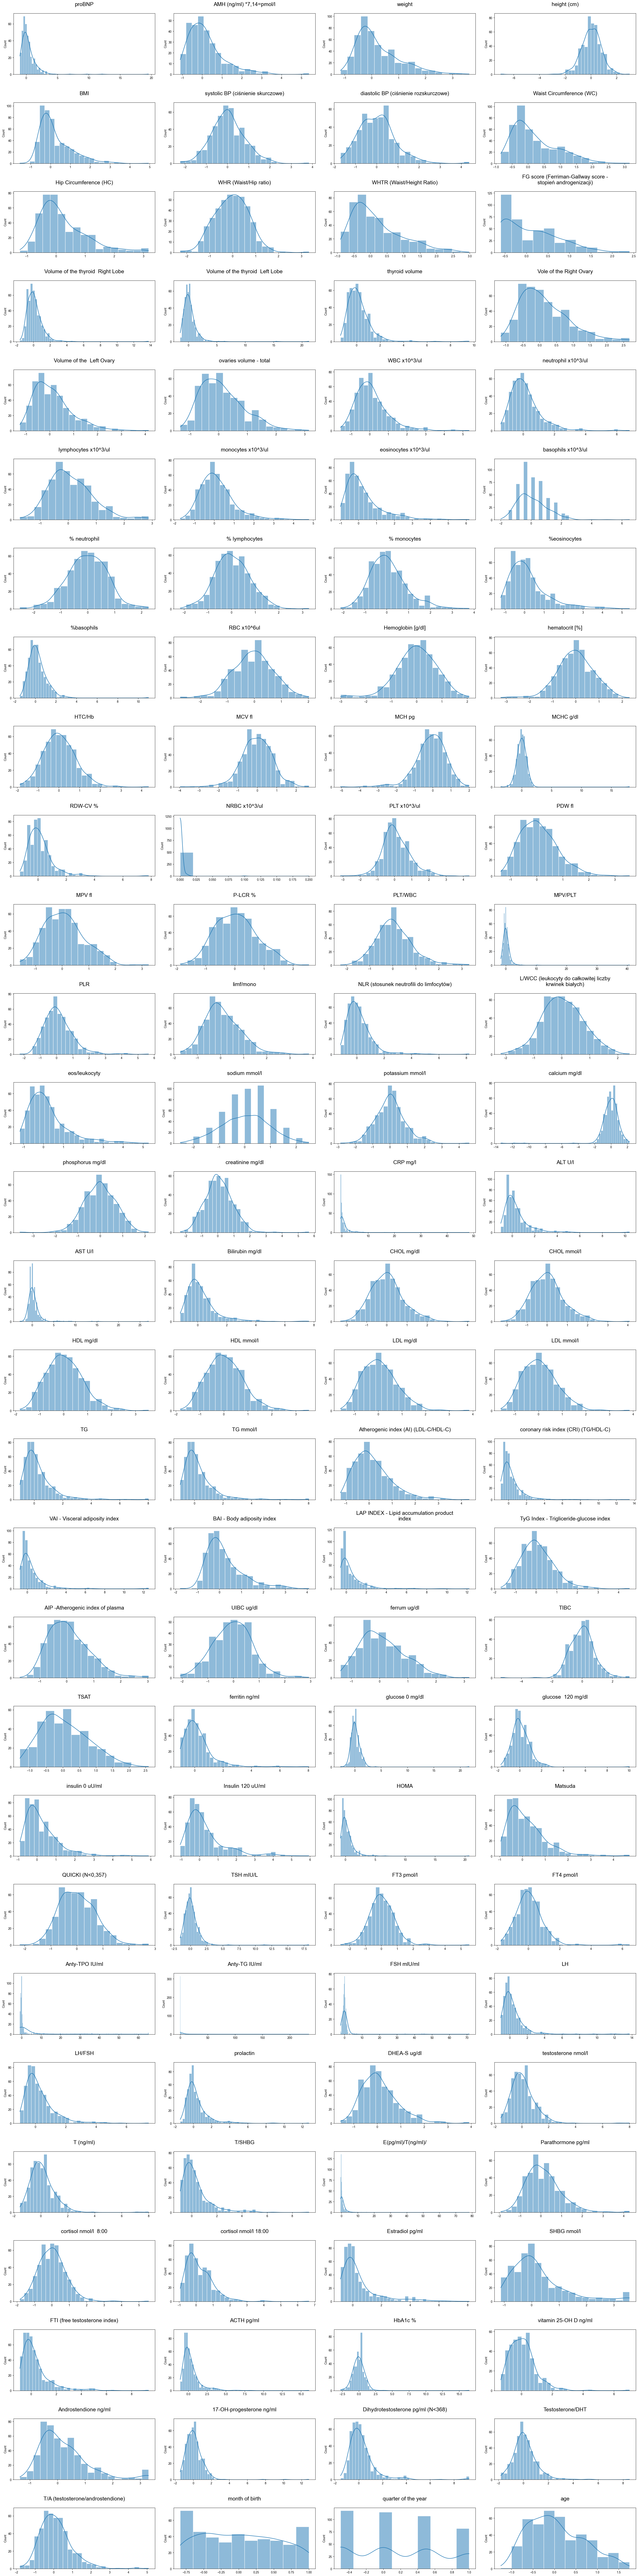

In [21]:
def plot_continuous_attribute_distributions(X, columns):
    n_rows = 29
    n_cols = 4

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 120))
    sns.set(font_scale = 1.5)

    for i, col in enumerate(columns):
        ax = axes[int(i/n_cols)][i%n_cols]
        sns.histplot(X[col], kde=True, ax=ax)
        ax.set_title("\n".join(wrap(col, 40)) + '\n')
        ax.set_xlabel('')

    fig.tight_layout()
    plt.show()

plot_continuous_attribute_distributions(X_train_robust_scaler, attributes_to_scale)

Power Transformer

## Handle missing data

- < 50% missing --> remove columns
- resztę -> zastapić mediana

In [22]:
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_robust_scaler), columns=X_train_robust_scaler.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test_robust_scaler), columns=X_test_robust_scaler.columns)

## One-hot encoding

One-hot encoding for PCO, overweight, nodules

In [23]:
cols_for_one_hot_encoding = {'PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro': 'PCO',
                             'overweight/obesity 0-normal/low, 1-overweight, 2-obesity': 'overweight',
                             'nodules 0-lack, 1-RL,  2-LL, 3-both': 'nodules',
                             'quarter of the year': 'birth_quarter',
                             'month of birth': 'birth_month',
                             }

new_column_names = {
    'PCO_0': '0_healthy_control',
    'PCO_1': '1_PCOS',
    'PCO_2': '2_FHA',
    'PCO_3': '3_POF',
    'PCO_4': '4_High_Andro',
    'overweight_0': '0_normal_weight',
    'overweight_1': '1_overweight',
    'overweight_2': '2_obesity',
    'nodules_0': '0_nodules',
    'nodules_1': '1_nodule',
    'nodules_2': '2_nodules',
    'nodules_3': '3_nodules',
    }


def perform_one_hot_encoding_for_columns(X, columns):
    for col, prefix in columns.items():
        X = pd.get_dummies(X, columns=[col], prefix=prefix, dtype=np.int8)
        # X.loc[X[col].isnull(), X.columns.str.startswith(f'{prefix}_')] = np.nan

    X = X.rename(columns=new_column_names)
    return X


X_train_preprocessed = perform_one_hot_encoding_for_columns(X_train_imputed, cols_for_one_hot_encoding)
X_test_preprocessed = perform_one_hot_encoding_for_columns(X_test_imputed, cols_for_one_hot_encoding)

# update categorical_attributes array
#  remove no longer existing columns
for col in cols_for_one_hot_encoding.keys():
    if col in categorical_attributes:
        categorical_attributes.remove(col)

# add new columns
for new_col in new_column_names.values():
    categorical_attributes.append(new_col)

In [24]:
X_train_preprocessed.head()

,proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Hypertension,Waist Circumference (WC),WC>88,Hip Circumference (HC),WHR (Waist/Hip ratio),"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)",WHTR (Waist/Height Ratio),"WHTR>0,5","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,FG score (Ferriman-Gallway score - stopień androgenizacji),hyperandrogenism,hypothyroidism,Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,chronic thyroiditis,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,follicules >12,hyperlipidemia,elevated LDL and TG,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,NRBC x10^3/ul,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,CHOL>200,HDL mg/dl,HDL mmol/l,HDL<50,LDL mg/dl,LDL mmol/l,LDL>135,TG,TG mmol/l,TG>150,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",Impaired Fasting Glucose,Impaired Glucose Tolerance,TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),age,PCO_0.0,PCO_1.0,PCO_2.0,PCO_3.0,PCO_4.0,overweight_0.0,overweight_1.0,overweight_2.0,nodules_0.0,nodules_1.0,nodules_2.0,nodules_3.0,birth_quarter_-0.5,birth_quarter_0.0,birth_quarter_0.5,birth_quarter_1.0,birth_month_-0.8333333333333334,birth_month_-0.6666666666666666,birth_month_-0.5,birth_month_-0.3333333333333333,birth_month_-0.16666666666666666,birth_month_0.0,birth_month_0.16666666666666666,birth_month_0.3333333333333333,birth_month_0.5,birth_month_0.6666666666666666,birth_month_0.8333333333333334,birth_month_1.0
0,-0.629541,-1.967295e-01,0.345455,0.444444,0.225948,0.111111,-0.041667,0.0,-0.25,0.0,0.235294,-1.083235,0.0,0.0,-0.366798,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.2,1.0,0.0,2.622529,2.180903,2.565227,1.0,0.000000,1.435484e-16,-1.454728e-16,0.0,0.0,0.0,-0.165770,0.049275,-0.425676,-0.611111,0.750000,-1.0,0.421053,-0.372727,-0.719101,0.927536,-0.50,0.00,0.076923,0.027586,-0.090394,-0.057692,-0.047619,0.100000,-0.818182,0.0,-0.655738,0.111111,0.083333,0.118227,-0.416280,0.732138,-0.105878,0.275336,0.436524,-0.371943,0.940456,0.5,-0.242424,0.243902,-0.098765,0.000000,-0.058824,-0.7,-1.000000,-0.275862,0.000000,0.000000,0.0,0.590909,0.590909,0.0,-0.079845,-0.079845,0.0,-0.590909,-0.590909,0.0,-0.324301,-0.526127,-0.509290,0.132174,-0.296402,-0.697173,-0.748553,0.000000,0.164948,0.034483,0.058824,0.032520,0.2,-0.172414,0.547561,-0.034234,0.514582,-0.277821,-0.414811,0.0,0.0,0.529524,-0.141844,-0.294833,-0.555556,-0.117647,0.08,0.052459,-0.033394,-0.014925,0.247934,-0.777778,-0.777778,-0.462445,0.273789,-0.374486,-0.892562,-0.778571,-0.247423,0.082090,-0.496949,-0.264337,-1.25,-1.000000,-0.014634,-0.759124,

### Baseline model

In [25]:
# X_train_preprocessed[attributes_to_scale] = X_train_preprocessed[attributes_to_scale].astype('Float64')

In [27]:
model = DecisionTreeRegressor(random_state=42)

# Fit the model on the training data
model.fit(X_train_preprocessed, y_train)

# Predict on the testing data
y_pred = model.predict(X_test_preprocessed)

# Calculate Mean Squared Error (MSE) as evaluation metric
mse = mean_squared_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R2 : {r2}")

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- birth_month_-0.2
- birth_month_-0.4
- birth_month_-0.6
- birth_month_-0.8
- birth_month_-1.0
- ...
Feature names seen at fit time, yet now missing:
- birth_month_-0.16666666666666666
- birth_month_-0.3333333333333333
- birth_month_-0.5
- birth_month_-0.6666666666666666
- birth_month_-0.8333333333333334
- ...


### Feature selection

In [28]:

lasso = Lasso(alpha=0.1)
lasso.fit(X_train_preprocessed, y_train)
importances = np.abs(lasso.coef_)

In [29]:

selector = SelectFromModel(model, threshold=0.1)
selector.fit(X_train_preprocessed, y_train)
selected_features = X_train_preprocessed.columns[selector.get_support()]
selected_features

Index(['age'], dtype='object')

In [30]:

result = permutation_importance(model, X_test_preprocessed, y_test, n_repeats=10, random_state=42)
importances = result.importances_mean

# # Associate each importance value with its corresponding feature name
feature_importances = dict(zip(X_test_preprocessed.columns, importances))

# Print the columns together with their importances
for feature, importance in feature_importances.items():
    if importance != 0:
        print(f"{feature}: {importance}")

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- birth_month_-0.2
- birth_month_-0.4
- birth_month_-0.6
- birth_month_-0.8
- birth_month_-1.0
- ...
Feature names seen at fit time, yet now missing:
- birth_month_-0.16666666666666666
- birth_month_-0.3333333333333333
- birth_month_-0.5
- birth_month_-0.6666666666666666
- birth_month_-0.8333333333333334
- ...


In [31]:
rfe = RFE(estimator=model, n_features_to_select=5)
rfe.fit(X_train_preprocessed, y_train)
importances = rfe.ranking_

feature_importances = dict(zip(X_test_preprocessed.columns, importances))

sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: x[1])

# Print the columns together with their importances
for feature, importance in sorted_feature_importances:
    if importance != 0:
        print(f"{feature}: {importance}")

WHR (Waist/Hip ratio): 1
% lymphocytes : 1
P-LCR %: 1
HOMA: 1
age: 1
ALT U/l: 2
hematocrit [%]: 3
PLT x10^3/ul: 4
Estradiol pg/ml: 5
LDL mmol/l: 6
MCH pg: 7
glucose  120 mg/dl: 8
Dihydrotestosterone pg/ml (N<368): 9
MPV fl: 10
CRP mg/l: 11
LH/FSH: 12
FT4 pmol/l: 13
FT3 pmol/l: 14
VAI - Visceral adiposity index: 15
ovaries volume - total: 16
neutrophil x10^3/ul: 17
RDW-CV %: 18
Matsuda: 19
TIBC: 20
Anty-TG IU/ml: 21
cortisol nmol/l  8:00: 22
TSH mIU/L: 23
T/SHBG: 24
thyroid volume: 25
CHOL mg/dl : 26
overweight_1.0: 27
FG score (Ferriman-Gallway score - stopień androgenizacji): 28
Hemoglobin [g/dl]: 29
lymphocytes x10^3/ul: 30
Anty-TPO IU/ml: 31
AST U/l: 32
Vole of the Right Ovary: 33
DHEA-S ug/dl: 34
nodules_0.0: 35
T (ng/ml): 36
potassium mmol/l: 37
SHBG nmol/l: 38
Atherogenic index (AI) (LDL-C/HDL-C) : 39
Volume of the thyroid  Left Lobe: 40
Parathormone pg/ml: 41
BAI - Body adiposity index: 42
% neutrophil : 43
QUICKI (N<0,357): 44
glucose 0 mg/dl: 45
birth_month_0.6: 46
Testosteron

In [32]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train_preprocessed, y_train)

# Get feature importances
importances = model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train_preprocessed.shape[1]):

    print(f"{f + 1}. Feature '{X_train_preprocessed.columns[indices[f]]}' ({importances[indices[f]]})")

Feature ranking:
1. Feature 'age' (0.11558109256072505)
2. Feature '% lymphocytes ' (0.037067424059781806)
3. Feature '17-OH-progesterone ng/ml' (0.02265471763561137)
4. Feature 'insulin 0 uU/ml' (0.02005921061817757)
5. Feature 'ALT U/l' (0.020031333707779757)
6. Feature 'TIBC' (0.018341271049474084)
7. Feature 'P-LCR %' (0.0180263764801652)
8. Feature 'DHEA-S ug/dl' (0.017381523781329275)
9. Feature 'E(pg/ml)/T(ng/ml)/' (0.013925019525298177)
10. Feature 'Dihydrotestosterone pg/ml (N<368)' (0.01381382592287395)
11. Feature 'FT3 pmol/l' (0.013211499351731826)
12. Feature 'MPV fl' (0.013196172022832464)
13. Feature 'QUICKI (N<0,357)' (0.012496564375672798)
14. Feature 'ferritin ng/ml' (0.011887067391901414)
15. Feature 'Hemoglobin [g/dl]' (0.011773180214576847)
16. Feature 'WHTR (Waist/Height Ratio)' (0.010941850797454569)
17. Feature 'neutrophil x10^3/ul' (0.01090754824336664)
18. Feature 'phosphorus mg/dl' (0.010880616821887323)
19. Feature 'SHBG nmol/l' (0.010875881110953065)
20. Fe

## Training pipeline

### Scaler

### Imputer

In [33]:
class MissingDataImputer:
    def __init__(self, 
                columns_to_drop_rows_if_missing_value=[],
                columns_to_impute_with_median=[],
                columns_to_impute_with_knn=[],
                columns_to_drop=[]):
        self.columns_to_drop_rows_if_missing_value = columns_to_drop_rows_if_missing_value
        self.columns_to_impute_with_median = columns_to_impute_with_median
        self.columns_to_impute_with_knn = columns_to_impute_with_knn
        self.columns_to_drop = columns_to_drop

    def impute(self, X, y):
        X, y = X.copy(), y.copy()

        # Drop rows for which the values in specified columns are missing
        if self.columns_to_drop_rows_if_missing_value:
            X.reset_index(drop=True, inplace=True)
            y.reset_index(drop=True, inplace=True)
            X = X.dropna(subset=self.columns_to_drop_rows_if_missing_value)
            y = y.loc[X.index] # leave only the relevant rows in y

        # Impute specified columns with median
        if self.columns_to_impute_with_median:
            #  TODO: fit transform only on the training set and only transform on the test set
            median_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
            X[self.columns_to_impute_with_median] = median_imputer.fit_transform(X[self.columns_to_impute_with_median])

        # Impute specified columns with knn
        if self.columns_to_impute_with_knn:
            #  TODO: fit transform only on the training set and only transform on the test set
            knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
            X[self.columns_to_impute_with_knn] = knn_imputer.fit_transform(X[self.columns_to_impute_with_knn])

        # Drop specified columns
        if self.columns_to_drop:
            X = X.drop(columns=self.columns_to_drop)
        
        return X, y